# Results on Stim/Unstim T cells dataset

0. [Readin data, basal state, outcome factor and loadings](#1)     
1. [Factor annotation](#3)
    1. [Selecting top genes in each factor](#5)
    1. [Gene set enrichment analysis](#6)
    1. [Some markers of T cells](#7)
2. [Growing generalized random forests (GRF)](#8)     
    1. [Growing GRF for one target to one factor](#9) 
    1. [Growing GRF for one target to all factors](#10)
    1. [Growing GRF for all targets to all factors](#11)
3. [Heterogeneous perturbation effects across stim/unstim cells](#12) 
    1. [Aggregating on stim cells](#13)
    1. [Aggregating on unstim cells](#14)
    1. [CD3D → Factor 3](#15)
    1. [TCEB2 → Factor 6](#16)
    1. [ARID1A → Factor 5](#17)
    1. [TMEM222 → Factor 7](#18)
4. [Characterizing subpopulations that response differently](#19)     
    1. [Drawing CATE and sig on UMAP](#20)     
    1. [Drawing jitter plot](#21)     
    1. [Specifying subclusters](#22) 
    1. [Drawing Jitter plot of subclusters](#23)
    1. [Drawing density plots to validate](#24)
    1. [The relationship between CATE and marker gene expression (LCP2→Factor7)](#25)
    1. [The relationship between CATE and marker gene expression (targets→Factor3)](#26)
    1. [The relationship between CATE and marker gene expression (targets→Factor7)](#27)
5. [Factor-level targets distance, and overall targets distance](#28)       
    1. [Factor 7 targets distance, aggregating on stim/unstim cells](#29)      
    1. [Overall targets distance, aggregating on stim/unstim cells](#30)     
6. [Factor-level targets ranking list, and overall targets ranking list](#31)
    1. [Factor-level targets ranking list, aggregating on stim/unstim cells](#32)
    1. [Overall targets ranking list, aggregating on stim/unstim cells](#33)
7. [Overall perturbation ranking along the stim trajectory](#34)
    1. [Constructing a trajectory](#35)
    1. [Overall ranking lists aggregating on subclusters](#36)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import gseapy as gp
from fractions import Fraction

In [2]:
from scCAPE import sccape
from scCAPE import plotting

<a id="1"></a> 
# 0 Readin data, basal state, outcome factor and loadings

Load the processed dataset. The processing is followed by the routine workflow stated in the tutorial of the scanpy package. To be more specific, the cells were removed if they meet one of the following conditions: 

1. the number of expressed gene is less than 200 ('sc.pp.filter_cells(adata, min_genes=200)');
2. the percentage of mitochondrial genes is larger than 10% (pct_counts_mt>10 in 'sc.pp.calculate_qc_metrics');
3. the number of genes expressed in the count matrix is larger than 5000 (n_genes_by_counts>5000 in 'sc.pp.calculate_qc_metrics').

The genes were removed if they were expressed in less than 3 cells ('sc.pp.filter_genes(adata, min_cells=3)'). Then the matrix was normalized and logarithmized using 'sc.pp.normalize_total' and 'sc.pp.log1p'. The highly-variable genes were identified using 'sc.pp.highly_variable_genes'.

In [3]:
data_path="data/SM2018_Tcells_processed.h5ad"
dataset_name="SM2018_Tcells"
fig_path1="all_figs/SM2018_Tcells_figs"
fig_path2="all_figs/supp_figs"

In [4]:
adata=sc.read_h5ad(data_path)
adata

AnnData object with n_obs × n_vars = 24918 × 6000
    obs: 'state', 'guide_id', 'condition', 'cell_type', 'condition_name', 'control'
    var: 'ncounts', 'ncells', 'n_cells', 'mt', 'n_cells_by_counts'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups_cov_all', 'state_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

The input adata of scCAPE contains the following metadata:
1. **'condition'**: The perturbation labels. **Note the label of control cells must be 'control'**;
2. **'cell_type'** (Not necessary): The cell states used in downstream analysis, which can be pre-defined or clustered using some unsupervised algorithms like 'leiden'. If not specified, scCAPE will perform leiden clustering using 'sc.tl.leiden(data, resolution=0.6)' when performing adversarial training;
3. **'condition_name'** (Not necessary) : The labels for performing DEG analysis, which will be used in evaluating reconsturction performance. If not specified, scCAPE will just copy the values in 'condition' when performing adversarial training;
4. **'control'** (Not necessary) : The dummy variable to show if the cell is control (1) or perturbed (0), which will be generated based on perturbation label when performing adversarial training in scCAPE. 

In [5]:
adata.obs.iloc[9:15,:]

state                   guide_id condition cell_type  \
cell_barcode                                                                    
AAACGGGAGCGAAGGG-D1_Stim  Stim               ES.sg16.DGKZ      DGKZ         5   
AAACGGGAGCTATGCT-D1_Stim  Stim  ES.sg43.NonTarget.CTRL108   control         5   
AAACGGGAGCTGTCTA-D1_Stim  Stim              ES.sg34.TCEB2     TCEB2         5   
AAACGGGAGGAGTCTG-D1_Stim  Stim            ES.sg36.TMEM222   TMEM222         5   
AAACGGGAGGCATGGT-D1_Stim  Stim            ES.sg4.C10orf54  C10orf54         4   
AAACGGGAGTGCGTGA-D1_Stim  Stim                ES.sg2.BTLA      BTLA         4   

                         condition_name  control  
cell_barcode                                      
AAACGGGAGCGAAGGG-D1_Stim           DGKZ        0  
AAACGGGAGCTATGCT-D1_Stim        control        1  
AAACGGGAGCTGTCTA-D1_Stim          TCEB2        0  
AAACGGGAGGAGTCTG-D1_Stim        TMEM222        0  
AAACGGGAGGCATGGT-D1_Stim       C10orf54        0  
AAACGGGAGTGCGTGA-D1_Stim           BTLA        0

The 'state' column represents the cell is TCR-stimulated (Stim) or not (NoStim). 

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


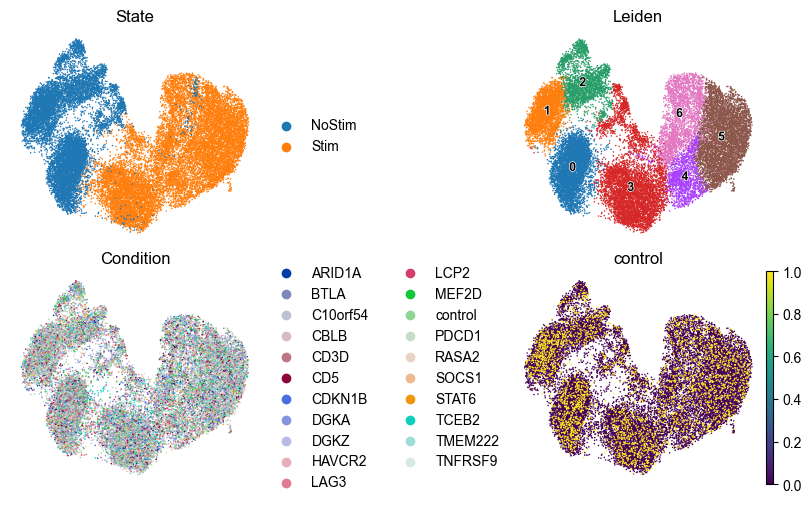

In [6]:
with plt.rc_context({'figure.figsize': (8, 5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,2,constrained_layout=True)
    sc.pl.umap(adata,color='state',title='State',frameon=False,ax=axs[0][0],show=False)
    sc.pl.umap(adata,color='cell_type',title='Leiden',legend_loc='on data',frameon=False,legend_fontsize=9, legend_fontoutline=1,ax=axs[0][1],show=False)
    sc.pl.umap(adata,color='condition',title='Condition',frameon=False,ax=axs[1][0],show=False)
    sc.pl.umap(adata,color='control',title='control',frameon=False,ax=axs[1][1],show=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_adata_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

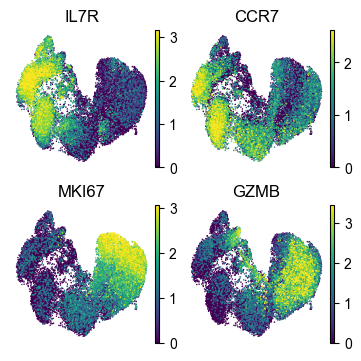

In [7]:
with plt.rc_context({'figure.figsize': (3.5, 3.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,2,constrained_layout=True)
    sc.pl.umap(adata, color=["IL7R"], frameon=False, vmax='p99',ax=axs[0][0],show=False)
    sc.pl.umap(adata, color=[ "CCR7"], frameon=False, vmax='p99',ax=axs[0][1],show=False)
    sc.pl.umap(adata, color=["MKI67"], frameon=False, vmax='p99',ax=axs[1][0],show=False)
    sc.pl.umap(adata, color=["GZMB"], frameon=False, vmax='p99',ax=axs[1][1],show=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_markers_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

Stimulated cells generally induced expression of cell-cycle genes (e.g., MKI67) and cytolytic granzymes (e.g., GZMB), while unstimulated cells largely expressed markers of a resting state, such as IL7R and CCR7.

Read in basal state:

In [8]:
model_index=0

In [9]:
basal=sc.read_h5ad(os.path.join(dataset_name,'CAPE','model_index={}_basal.h5ad'.format(model_index)))
sc.pp.neighbors(basal, n_neighbors=10)
sc.tl.umap(basal)

In [10]:
basal.write(os.path.join(dataset_name,'CAPE','model_index={}_basal_umap.h5ad'.format(model_index)))

In [11]:
basal=sc.read_h5ad(os.path.join(dataset_name,'CAPE','model_index={}_basal_umap.h5ad'.format(model_index)))

In [12]:
basal.obs['state']=adata.obs['state']
basal.obs['control']=adata.obs['control']
basal.uns['condition_colors']=adata.uns['condition_colors']
basal.uns['cell_type_colors']=adata.uns['cell_type_colors']

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


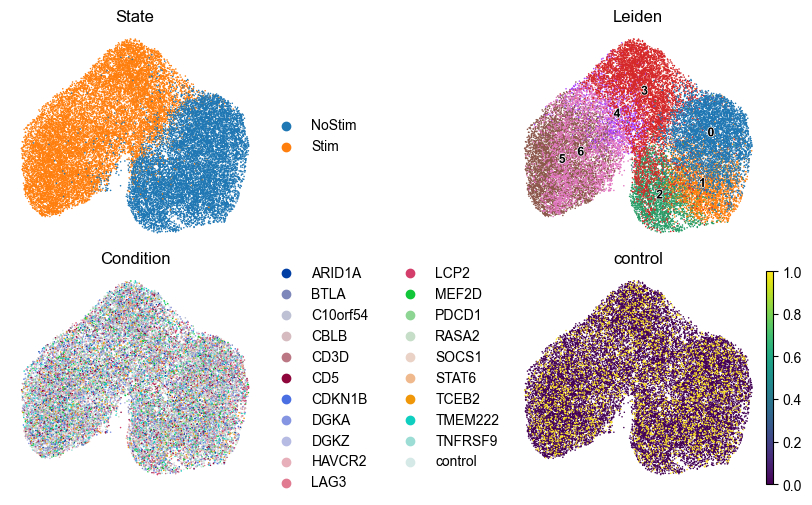

In [13]:
with plt.rc_context({'figure.figsize': (8, 5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,2,constrained_layout=True)
    sc.pl.umap(basal,color='state',title='State',frameon=False,ax=axs[0][0],show=False)
    sc.pl.umap(basal,color='cell_type',title='Leiden',legend_loc='on data',frameon=False,legend_fontsize=9, legend_fontoutline=1,ax=axs[0][1],show=False)
    sc.pl.umap(basal,color='condition',title='Condition',frameon=False,ax=axs[1][0],show=False)
    sc.pl.umap(basal,color='control',title='control',frameon=False,ax=axs[1][1],show=False)
    plt.show()

Read in outcome factors (treated) and factor loadings :

In [14]:
treated=sc.read_h5ad(os.path.join(dataset_name,'CAPE','model_index={}_treated.h5ad'.format(model_index)))
gene_loading=np.load(os.path.join(dataset_name,'CAPE','model_index={}_gene_loading.npy'.format(model_index)))
gene_loading_df=pd.DataFrame(gene_loading,columns=adata.var_names)

In [15]:
gene_loading.shape[0]

8

# 1 Factor annotation

Then we annotate the functions of each factor based on the loading matrix.

<a id="5"></a> 
## 1.1 select top genes in each factor

Selecting the genes with loadings > 2*std in each factor.

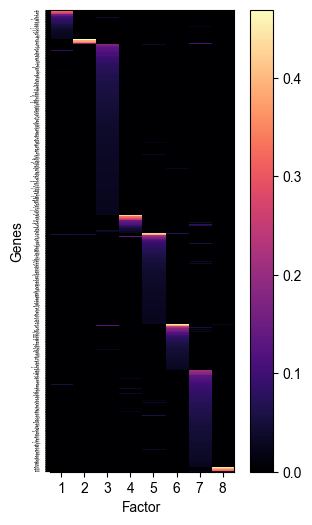

In [16]:
genes_do_go=plotting.plot_top_genes_loadings(gene_names=adata.var_names,W=gene_loading.T,
                                             figsize=(10,6), save_path=None, save=False)

For example, the high-loading genes in factor 7 (In python the index begins from 0).

In [17]:
adata.var_names[genes_do_go['6']]

Index(['H2AFZ', 'TUBA1B', 'HMGN2', 'HMGB2', 'TUBB', 'HIST1H4C', 'STMN1',
       'LDHA', 'DUT', 'DEK',
       ...
       'TPRG1', 'MT-ND2', 'DBI', 'PRC1', 'MT-ND6', 'CASC5', 'PLK1', 'CDCA5',
       'C12orf75', 'BRCA2'],
      dtype='object', name='gene_symbol', length=164)

<a id="6"></a> 
## 1.2 Gene set enrichment analysis

In [18]:
for factor in range(gene_loading.shape[0]):
    go_res = gp.enrichr(gene_list=list(adata.var_names[genes_do_go[str(factor)]]),
                    organism='Human',
                    gene_sets='GO_Biological_Process_2023')
    go_res_df=go_res.results[go_res.results['Adjusted P-value']<=0.05]
    go_res_df['Term']=[term.split(' (')[0] for term in go_res_df.Term.values]
    go_res_df['Overlap']=[float(Fraction(i)) for i in go_res_df.Overlap.values]
    go_res_df.to_csv(os.path.join(dataset_name,'CAPE','GO_factor_{}.csv'.format(factor)))
    print('Finish: {}'.format(factor))

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\3052123951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_res_df['Term']=[term.split(' (')[0] for term in go_res_df.Term.values]
C:\Users\17794\AppData\Local\Temp\ipykernel_21236\3052123951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_res_df['Overlap']=[float(Fraction(i)) for i in go_res_df.Overlap.values]


Finish: 0
Finish: 1
Finish: 2
Finish: 3
Finish: 4
Finish: 5
Finish: 6
Finish: 7


In [19]:
GO_total_df=pd.DataFrame([])
num_selected=[3,3,3,3,3,3,3,3]
for factor in range(8):
    GO_df=pd.read_csv(os.path.join(dataset_name,'CAPE','GO_factor_{}.csv'.format(factor)))
    selected_pathway_nums=min(len(GO_df),num_selected[factor])
    if selected_pathway_nums==0:
        pass
    else:
        GO_df=(GO_df.loc[:,['Term','Adjusted P-value','Overlap']]).head(selected_pathway_nums)
        GO_df['Factor']=factor
        GO_total_df=GO_total_df.append(GO_df,ignore_index = True)

In [20]:
GO_total_df.head(4)

Term  Adjusted P-value  \
0             Cellular Response To Cytokine Stimulus      2.418758e-02   
1                     Sequestering Of Actin Monomers      2.418758e-02   
2  Regulation Of CD8-positive, Alpha-Beta T Cell ...      2.418758e-02   
3                            Cytoplasmic Translation      4.332628e-08   

    Overlap  Factor  
0  0.019481       0  
1  0.250000       0  
2  0.222222       0  
3  0.053763       1

In [21]:
GO_total_df['y_ticks']=(0.2*GO_total_df.index)[::-1]
GO_total_df['Adjusted P-value']=-np.log10(GO_total_df['Adjusted P-value'])
for i in range(len(GO_total_df)):
    for j in range(i):
        if GO_total_df.loc[i,'Term']==GO_total_df.loc[j,'Term']:
            GO_total_df.loc[i,'y_ticks']=GO_total_df.loc[j,'y_ticks']
            GO_total_df.loc[(i+1):(len(GO_total_df)-1),'y_ticks']=GO_total_df.loc[(i+1):(len(GO_total_df)-1),'y_ticks']+0.2

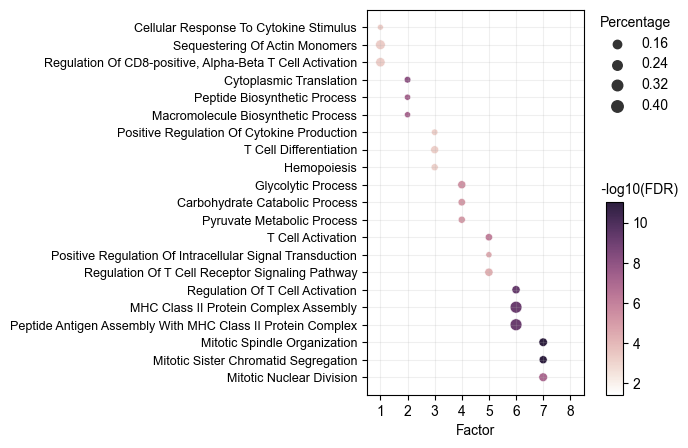

In [22]:
factor_nums=8
with plt.rc_context({'figure.figsize': (2.8, 5),'font.sans-serif':['Arial']}):
    fig, ax = plt.subplots()
    g=sns.scatterplot(data=GO_total_df,x = 'Factor', y ='y_ticks' , hue='Adjusted P-value',size='Overlap', ax=ax)
    h,l = g.get_legend_handles_labels()
    plt.legend(h[8:12],l[8:12],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False,title='Percentage')
    plt.xticks(np.arange(factor_nums),np.arange(factor_nums)+1)
    plt.yticks((GO_total_df.drop_duplicates(subset = "Term"))['y_ticks'],
               (GO_total_df.drop_duplicates(subset = "Term"))['Term'], fontsize=9)
    plt.ylabel('')
    plt.grid(alpha=0.2) 
    plt.xlim([-0.5,7.5])
    norm = plt.Normalize(GO_total_df['Adjusted P-value'].min(), GO_total_df['Adjusted P-value'].max())
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.add_axes([ax.get_position().x1+0.08, ax.get_position().y0, 0.06, ax.get_position().height / 2])
    cbar=ax.figure.colorbar(sm, cax=cax)
    cbar.ax.set_title('             -log10(FDR)',fontsize=10)
    #plt.savefig(os.path.join(fig_path1,'Tcells_GO_res.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="7"></a> 
## 1.3 Some markers of T cells

In [23]:
geneset=['IL7R','CCR7','PASK','SLFN5','ITGA4',
         'GNLY','CD69','HLA-DRA','HLA-DRB1','HLA-DRB5','XCL1','TNFRSF18','H2AFZ',
         'MKI67','HIST1H4C','GZMB','TOP2A','UBE2S','CENPF','IL2RA','NUSAP1','IFNG']

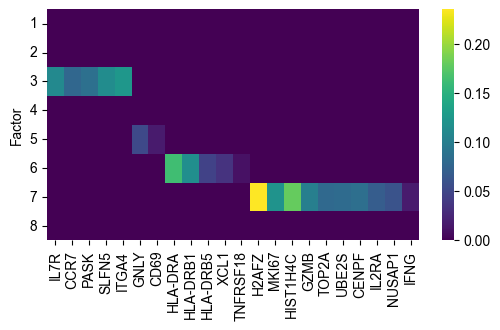

In [24]:
with plt.rc_context({'figure.figsize': (6, 3),'font.sans-serif':['Arial']}):
    sns.heatmap(gene_loading_df.loc[:,geneset],cmap='viridis')
    plt.xlabel('')
    plt.ylabel('Factor')
    plt.yticks(np.arange(8)+0.5,np.arange(8)+1,rotation=0)
    #plt.savefig(os.path.join(fig_path2,'Tcells_factor_loadings.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

Factor 3: T cell resting, Factor 5/6: T cell activation, Factor 7: T cell proliferation

<a id="8"></a> 
# 2 Causal Forests

<a id="9"></a> 
## 2.1 Run GRF for one target to one factor

Run the following function to study the perturbation effects of LCP2 to factor 7 (proliferation). 

'tau_factor_mean': CATE of each cell [**CATE**: conditional average treatment effect, which refers to heterogeneous perturbation effect here], 'tau_q_val_factor': q-value of each cell, 'sig_factor': siginificant (1) or not (0) of each cell.

In [25]:
tau_factor_mean,tau_q_val_factor,sig_factor=sccape.CF_single_target_single_factor(target='LCP2', factor=6, basal=basal,
                                                                                   treated=treated, adata=adata,
                                                                                   pert_key='condition', n_estimators=2000,
                                                                                   min_samples_leaf=5, 
                                                                                   random_state=1, alpha=0.05)

Plot the CATE, qvalue and sig on original UMAP.

C:\ProgramData\anaconda\lib\site-packages\scCAPE\plotting.py:159: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_subset.obs['CATE'] = tau_factor_mean
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


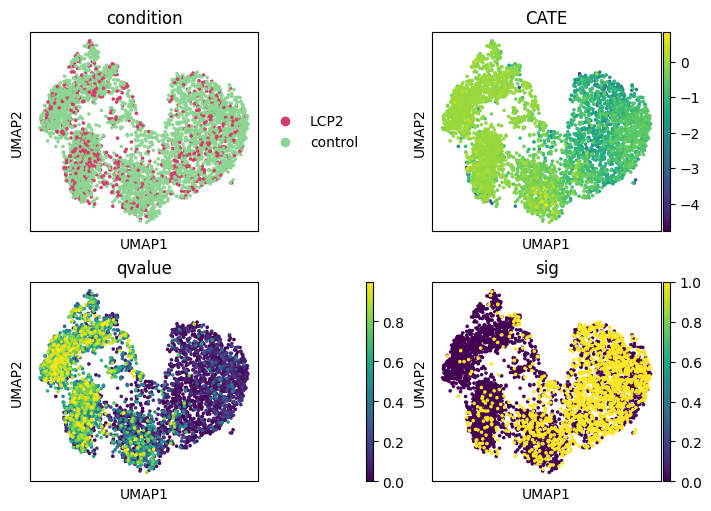

In [26]:
plotting.plot_CATE(data=adata, target='LCP2', tau_factor_mean=tau_factor_mean,
                   tau_q_val_factor=tau_q_val_factor, sig_factor=sig_factor, pert_key='condition',
                   figsize=(7, 5),save_path=None, save=False)

Plot the CATE, qvalue and sig on basal UMAP.

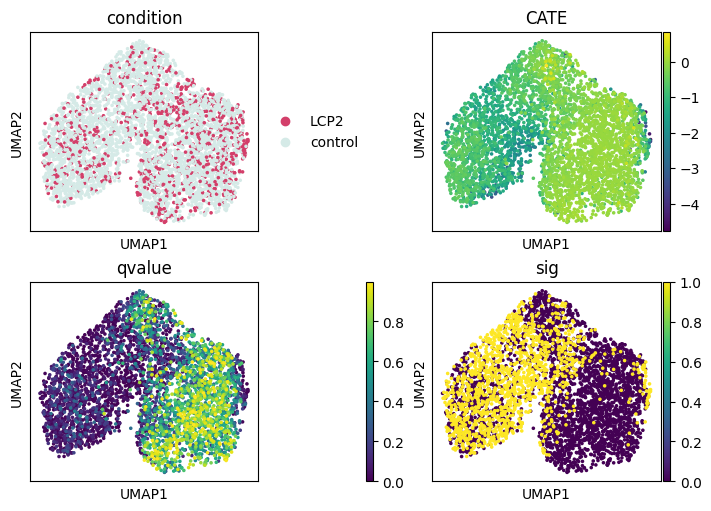

In [27]:
plotting.plot_CATE(data=basal, target='LCP2', tau_factor_mean=tau_factor_mean,
                   tau_q_val_factor=tau_q_val_factor, sig_factor=sig_factor, pert_key='condition',
                  figsize=(7, 5),save_path=None, save=False)

<a id="10"></a> 
## 2.2 Run GRF for one target to all factors

Run the following function to study the perturbation effects of LCP2 to all factors. 

In [28]:
tau_factor_mean,tau_q_val_factor,sig_factor=sccape.CF_single_target_all_factor(target='LCP2', basal=basal,
                                                                        treated=treated, adata=adata,
                                                                        pert_key='condition', n_estimators=2000,
                                                                        min_samples_leaf=5, 
                                                                        random_state=0, alpha=0.05)

'tau_factor_mean' [cell\*factors] : CATE on each factor of each cell , 
'tau_q_val_factor'[cell\*factors]: q-value on each factor of each cell,
'sig_factor'[cell\*factors]: siginificant (1) or not (0) on each factor of each cell.

In [29]:
tau_factor_mean.shape

(4496, 8)

<a id="11"></a> 
## 2.3 Run GRF for all targets to all factors

Run the following function to study the perturbation effects of all targets to all factors. CAUTION: This will take about 2 hours on a laptop.

In [30]:
sccape.CF_all_target_all_factor(dataset_name=dataset_name, basal=basal, treated=treated, adata=adata,
                                 pert_key='condition', n_estimators=2000,
                                 min_samples_leaf=5, 
                                 verbose=True, random_state=0, alpha=0.05)

Finish: ARID1A
Finish: BTLA
Finish: C10orf54
Finish: CBLB
Finish: CD3D
Finish: CD5
Finish: CDKN1B
Finish: DGKA
Finish: DGKZ
Finish: HAVCR2
Finish: LAG3
Finish: LCP2
Finish: MEF2D
Finish: PDCD1
Finish: RASA2
Finish: SOCS1
Finish: STAT6
Finish: TCEB2
Finish: TMEM222
Finish: TNFRSF9
Finish growing causal forests. See the results in folder:SM2018_Tcells\CausalForests


The function outputs three dictionaries in './dataset_name/CausalForests': **'tau_factor_mean_all_dict.pkl'**, **'tau_q_val_factor_all_dict.pkl'** and **'sig_factor_all_dict.pkl'**. The keys of the dicts are perturbations, and the values are cells\*factors array which gives CATE, qvalue and significance on each factor of each cell.

In [31]:
with open(os.path.join(dataset_name,'CausalForests','tau_factor_mean_all_dict.pkl'), 'rb') as fp:
    tau_factor_mean_all_dict = pickle.load(fp)
with open(os.path.join(dataset_name,'CausalForests','tau_q_val_factor_all_dict.pkl'), 'rb') as fp:
    tau_q_val_factor_all_dict = pickle.load(fp)
with open(os.path.join(dataset_name,'CausalForests','sig_factor_all_dict.pkl'), 'rb') as fp:
    sig_factor_all_dict = pickle.load(fp)

<a id="12"></a> 
# 3 Heterogeneous perturbation effects across Stim/Unstim cells

In [32]:
clust_mean_df, clust_sig_df=sccape.cal_clust_mean(adata, tau_factor_mean_all_dict, sig_factor_all_dict, 
                                                   aggregate_key='state', pert_key='condition')

In [33]:
clust_mean_df.head(6)

0         1         2         3         4         5         6  \
0  0.036765  0.044661 -0.426315  0.083317 -0.382325 -0.004338  0.104975   
1 -0.027777  0.047680 -0.156760  0.084222 -0.324919 -0.007053 -0.063541   
2  0.000591  0.046353 -0.275236  0.083824 -0.350150 -0.005859  0.010526   
3  0.057860  0.032697 -0.194218  0.035349 -0.107748  0.071589 -0.001087   
4  0.067579  0.071539  0.055180  0.031077 -0.100878 -0.021816 -0.132837   
5  0.063307  0.054467 -0.054436  0.032955 -0.103898  0.019238 -0.074930   

          7 cell_state  target  
0  0.034599     NoStim  ARID1A  
1  0.036132       Stim  ARID1A  
2  0.035458        All  ARID1A  
3  0.023543     NoStim    BTLA  
4  0.014754       Stim    BTLA  
5  0.018617        All    BTLA

In [34]:
clust_sig_df.head(6)

0         1         2         3         4    5    6         7  \
0  0.005814  0.067183  0.161499  0.005168  0.693798  0.0  0.0  0.003876   
1  0.001013  0.030902  0.030395  0.015704  0.644883  0.0  0.0  0.003040   
2  0.003123  0.046848  0.088018  0.011073  0.666383  0.0  0.0  0.003407   
3  0.009690  0.029716  0.012920  0.005168  0.056848  0.0  0.0  0.023256   
4  0.002533  0.210740  0.000000  0.022796  0.063323  0.0  0.0  0.011651   
5  0.005679  0.131175  0.005679  0.015048  0.060477  0.0  0.0  0.016752   

  cell_state  target  
0     NoStim  ARID1A  
1       Stim  ARID1A  
2        All  ARID1A  
3     NoStim    BTLA  
4       Stim    BTLA  
5        All    BTLA

<a id="13"></a> 
## 3.1 Aggregating on stim cells

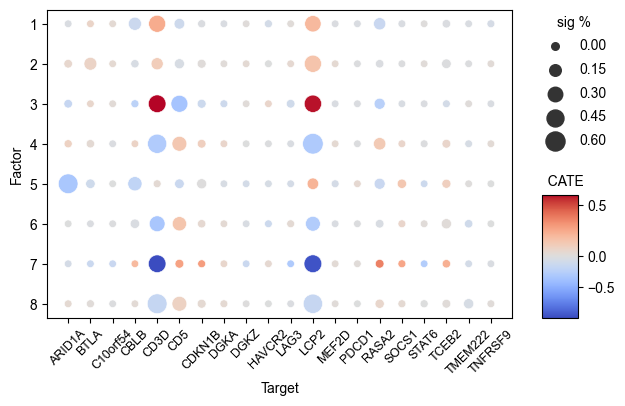

In [35]:
plotting.dotplot_pert_factor(clust_mean_df, clust_sig_df, cluster_name='Stim', color_min=None, color_max=None,
                        figsize=(6, 4), save_path=fig_path2, save=False)

<a id="14"></a> 
## 3.2 Aggregating on unstim cells

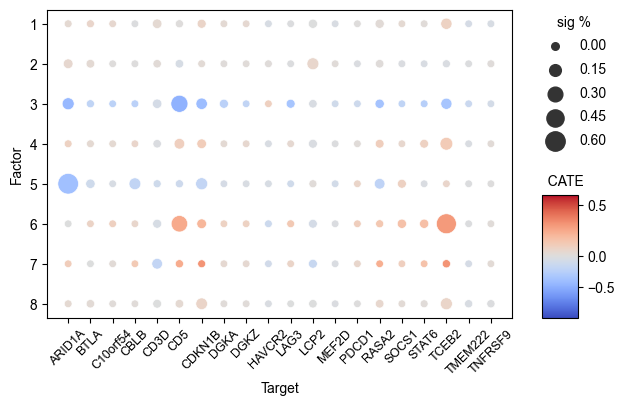

In [36]:
plotting.dotplot_pert_factor(clust_mean_df, clust_sig_df, cluster_name='NoStim', color_min=-0.99, color_max=0.6,
                            figsize=(6, 4), save_path=fig_path1, save=False)# change to fig_path1 when publishing

<a id="15"></a> 
## 3.3 CD3D → Factor 3 

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\361625197.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


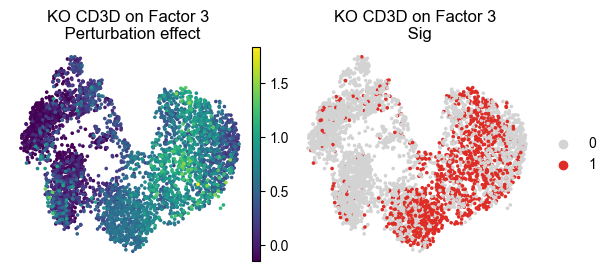

In [37]:
target='CD3D'
factor=2
# draw on orginal transcriptome UMAP
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
adata_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
adata_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]


with plt.rc_context({'figure.figsize': (6, 2.6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,2,constrained_layout=True)
    sc.pl.umap(adata_subset,color='te',title='KO {} on Factor {} \n Perturbation effect'.format(target,factor+1),frameon=False,ax=axs[0],show=False,vmin=-0.15)
    sc.pl.umap(adata_subset,color='sig',title='KO {} on Factor {} \n Sig'.format(target,factor+1),frameon=False,palette={
        "0": "lightgrey",
        "1": '#de2d26' },ax=axs[1],show=False)
    #plt.savefig(os.path.join(fig_path1,'Tcells_CD3D_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

CD3D exerts its perturbation effects on T cell resting markers (Factor 3) only at stim cells.

Visualizing the factor 3 expression of CD3D/ctrl on stim/unstim cells to validate this: 

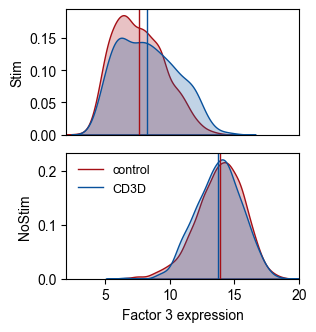

In [38]:
target='CD3D'
adata.obs['factor3']=adata.X@gene_loading[2,:]
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
density_df=adata_subset.obs.loc[:,['factor3','state','control']]
with plt.rc_context({'figure.figsize': (3, 3.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,gridspec_kw = {'wspace':0, 'hspace':0.15})
    clust=['Stim','NoStim']
    for i in range(2):
        sub_density_df=density_df.loc[density_df['state']==clust[i]]
        subsub_density_df_ctrl=sub_density_df.loc[sub_density_df['control']==1,:]
        subsub_density_df_pert=sub_density_df.loc[sub_density_df['control']==0,:]
        sns.kdeplot(subsub_density_df_ctrl['factor3'], shade=True, color="#a50f15",ax=axs[i])
        axs[i].set_xlabel(' ')
        axs[i].set_ylabel(clust[i])
        axs[i].set_xlim([2,20])
        if i!=1:
            axs[i].set_xticks([])
        axs[i].axvline(x=np.mean(subsub_density_df_ctrl['factor3']), color='#a50f15', ls='-', lw=1, label='control')
        sns.kdeplot(subsub_density_df_pert['factor3'], shade=True, color="#08519c",ax=axs[i])
        axs[i].axvline(x=np.mean(subsub_density_df_pert['factor3']), color='#08519c', ls='-', lw=1, label='CD3D')
    axs[1].set_xlabel('Factor 3 expression')
    plt.legend(fontsize=9, frameon=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_CD3D_validation.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="16"></a> 
## 3.4 TCEB2 → Factor 6

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\180671124.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


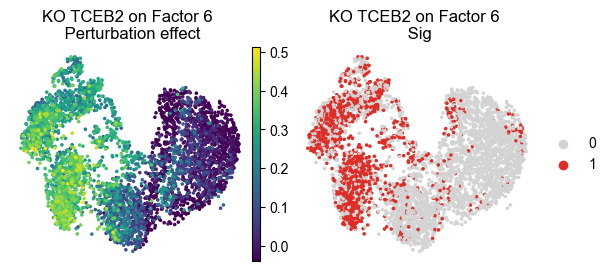

In [39]:
target='TCEB2'
factor=5
# draw on orginal transcriptome UMAP
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
adata_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
adata_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]


with plt.rc_context({'figure.figsize': (6, 2.6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,2,constrained_layout=True)
    sc.pl.umap(adata_subset,color='te',title='KO {} on Factor {} \n Perturbation effect'.format(target,factor+1),frameon=False,ax=axs[0],show=False,vmin=-0.04)
    sc.pl.umap(adata_subset,color='sig',title='KO {} on Factor {} \n Sig'.format(target,factor+1),frameon=False,palette={
        "0": "lightgrey",
        "1": '#de2d26' },ax=axs[1],show=False)
    #plt.savefig(os.path.join(fig_path1,'Tcells_TCEB2_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

TCEB2 exerts its perturbation effects on Factor 6 only at unstim cells.

Visualizing the factor 6 expression of TCEB2/ctrl on stim/unstim cells to validate this: 

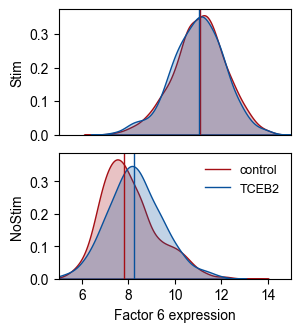

In [40]:
target='TCEB2'
adata.obs['factor6']=adata.X@gene_loading[5,:]
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
density_df=adata_subset.obs.loc[:,['factor6','state','control']]
with plt.rc_context({'figure.figsize': (3, 3.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,gridspec_kw = {'wspace':0, 'hspace':0.15})
    clust=['Stim','NoStim']
    for i in range(2):
        sub_density_df=density_df.loc[density_df['state']==clust[i]]
        subsub_density_df_ctrl=sub_density_df.loc[sub_density_df['control']==1,:]
        subsub_density_df_pert=sub_density_df.loc[sub_density_df['control']==0,:]
        sns.kdeplot(subsub_density_df_ctrl['factor6'], shade=True, color="#a50f15",ax=axs[i])
        axs[i].set_xlabel(' ')
        axs[i].set_ylabel(clust[i])
        axs[i].set_xlim([5,15])
        if i!=1:
            axs[i].set_xticks([])
        axs[i].axvline(x=np.median(subsub_density_df_ctrl['factor6']), color='#a50f15', ls='-', lw=1, label='control')
        sns.kdeplot(subsub_density_df_pert['factor6'], shade=True, color="#08519c",ax=axs[i])
        axs[i].axvline(x=np.median(subsub_density_df_pert['factor6']), color='#08519c', ls='-', lw=1, label='TCEB2')
    axs[1].set_xlabel('Factor 6 expression')
    plt.legend(fontsize=9, frameon=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_TCEB2_validation.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="17"></a> 
## 3.5 ARID1A → Factor 5

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\1902961292.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


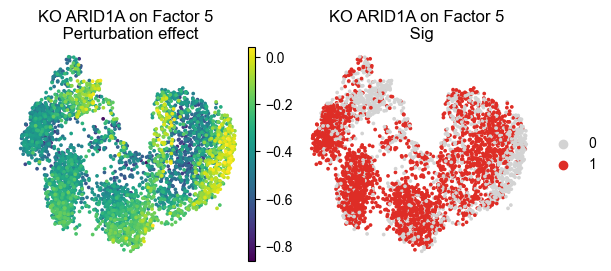

In [41]:
target='ARID1A'
factor=4
# draw on orginal transcriptome UMAP
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
adata_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
adata_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]


with plt.rc_context({'figure.figsize': (6, 2.6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,2,constrained_layout=True)
    sc.pl.umap(adata_subset,color='te',title='KO {} on Factor {} \n Perturbation effect'.format(target,factor+1),frameon=False,ax=axs[0],vmax=0.04,show=False)
    sc.pl.umap(adata_subset,color='sig',title='KO {} on Factor {} \n Sig'.format(target,factor+1),frameon=False,palette={
        "0": "lightgrey",
        "1": '#de2d26' },ax=axs[1],show=False)
    #plt.savefig(os.path.join(fig_path1,'Tcells_ARID1A_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

ARID1A exerts its perturbation effects on Factor 5 at both stim and unstim cells.

Visualizing the factor 5 expression of ARID1A/ctrl on stim/unstim cells to validate this: 

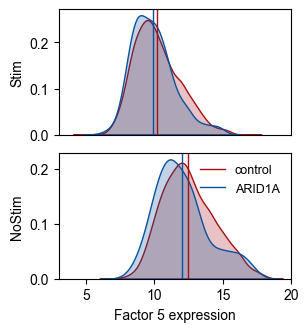

In [42]:
target='ARID1A'
adata.obs['factor5']=adata.X@gene_loading[4,:]
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
density_df=adata_subset.obs.loc[:,['factor5','state','control']]
with plt.rc_context({'figure.figsize': (3, 3.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,gridspec_kw = {'wspace':0, 'hspace':0.15})
    clust=['Stim','NoStim']
    for i in range(2):
        sub_density_df=density_df.loc[density_df['state']==clust[i]]
        subsub_density_df_ctrl=sub_density_df.loc[sub_density_df['control']==1,:]
        subsub_density_df_pert=sub_density_df.loc[sub_density_df['control']==0,:]
        sns.kdeplot(subsub_density_df_ctrl['factor5'], shade=True, color="#a50f15",ax=axs[i])
        axs[i].set_xlabel(' ')
        axs[i].set_ylabel(clust[i])
        axs[i].set_xlim([3,20])
        if i!=1:
            axs[i].set_xticks([])
        axs[i].axvline(x=np.mean(subsub_density_df_ctrl['factor5']), color='#a50f15', ls='-', lw=1, label='control')
        sns.kdeplot(subsub_density_df_pert['factor5'], shade=True, color="#08519c",ax=axs[i])
        axs[i].axvline(x=np.mean(subsub_density_df_pert['factor5']), color='#08519c', ls='-', lw=1, label='ARID1A')
    axs[1].set_xlabel('Factor 5 expression')
    plt.legend(fontsize=9, frameon=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_ARID1A_validation.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="18"></a> 
## 3.6 TMEM222 → Factor 7

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\3394622462.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


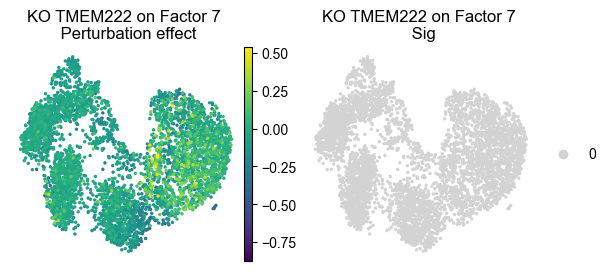

In [43]:
target='TMEM222'
factor=6
# draw on orginal transcriptome UMAP
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
adata_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
adata_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]


with plt.rc_context({'figure.figsize': (6, 2.6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1,2,constrained_layout=True)
    sc.pl.umap(adata_subset,color='te',title='KO {} on Factor {} \n Perturbation effect'.format(target,factor+1),frameon=False,ax=axs[0],show=False)
    sc.pl.umap(adata_subset,color='sig',title='KO {} on Factor {} \n Sig'.format(target,factor+1),frameon=False,palette={
        "0": "lightgrey",
        "1": '#de2d26' },ax=axs[1],show=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_TMEM222_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

TMEM222 has no perturbation effects on Factor 7.

Visualizing the factor 7 expression of TMEM222/ctrl on stim/unstim cells to validate this: 

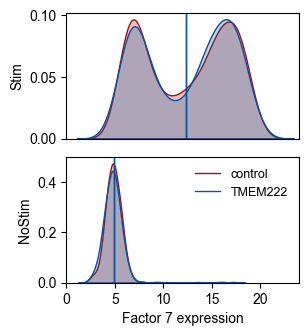

In [44]:
target='TMEM222'
adata.obs['factor7']=adata.X@gene_loading[6,:]
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
density_df=adata_subset.obs.loc[:,['factor7','state','control']]
with plt.rc_context({'figure.figsize': (3, 3.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,gridspec_kw = {'wspace':0, 'hspace':0.15})
    clust=['Stim','NoStim']
    for i in range(2):
        sub_density_df=density_df.loc[density_df['state']==clust[i]]
        subsub_density_df_ctrl=sub_density_df.loc[sub_density_df['control']==1,:]
        subsub_density_df_pert=sub_density_df.loc[sub_density_df['control']==0,:]
        sns.kdeplot(subsub_density_df_ctrl['factor7'], shade=True, color="#a50f15",ax=axs[i])
        axs[i].set_xlabel(' ')
        axs[i].set_ylabel(clust[i])
        axs[i].set_xlim([0,24])
        if i!=1:
            axs[i].set_xticks([])
        axs[i].axvline(x=np.mean(subsub_density_df_ctrl['factor7']), color='#a50f15', ls='-', lw=1, label='control')
        sns.kdeplot(subsub_density_df_pert['factor7'], shade=True, color="#08519c",ax=axs[i])
        axs[i].axvline(x=np.mean(subsub_density_df_pert['factor7']), color='#08519c', ls='-', lw=1, label='TMEM222')
    axs[1].set_xlabel('Factor 7 expression')
    plt.legend(fontsize=9, frameon=False)
    #plt.savefig(os.path.join(fig_path2,'Tcells_TMEM222_validation.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="19"></a> 
# 4 Characterize subpopulations that response differently

Take LCP2→Factor 7 as an example.

<a id="20"></a> 
## 4.1 Drawing CATE and sig on original UMAP

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\516547274.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


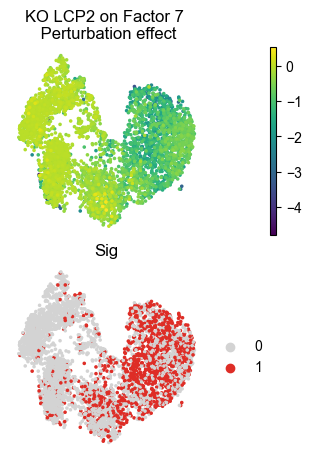

In [45]:
target='LCP2'
factor=6
# draw on orginal transcriptome UMAP
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
adata_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
adata_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]


with plt.rc_context({'figure.figsize': (3, 4.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,constrained_layout=True)
    sc.pl.umap(adata_subset,color='te',title='KO {} on Factor {} \n Perturbation effect'.format(target,factor+1),frameon=False,ax=axs[0],show=False)
    sc.pl.umap(adata_subset,color='sig',title='Sig',frameon=False,palette={
        "0": "lightgrey",
        "1": '#de2d26' },ax=axs[1],show=False)
    #plt.savefig(os.path.join(fig_path1,'Tcells_LCP2_UMAP.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="21"></a> 
## 4.2 Jitterplot

In [46]:
tau_factor_mean_ctrl_dict={}
tau_q_val_factor_ctrl_dict={}
sig_factor_ctrl_dict={}
for pert in tau_factor_mean_all_dict.keys():
    subset=basal[basal.obs.condition.isin([pert,'control'])]
    ctrl_idx=np.where(subset.obs['condition']=='control')[0]
    tau_factor_mean_ctrl_dict[pert]=tau_factor_mean_all_dict[pert][ctrl_idx,:]
    tau_q_val_factor_ctrl_dict[pert]=tau_q_val_factor_all_dict[pert][ctrl_idx,:]
    sig_factor_ctrl_dict[pert]=sig_factor_all_dict[pert][ctrl_idx,:]

In [47]:
ctrl_cells_name=subset.obs.iloc[np.where(subset.obs['condition']=='control')[0],:].index
ctrl_cells_cell_type=subset.obs.iloc[np.where(subset.obs['condition']=='control')[0],:]['state']

In [48]:
import scprep

In [49]:
target='LCP2'
factor=6
jitterdata=pd.DataFrame(np.array([tau_factor_mean_ctrl_dict[target][:,factor],
                         tau_q_val_factor_ctrl_dict[target][:,factor],
                         ctrl_cells_cell_type.values]).T,columns=['CATE','qvalue','cell_state'],index=ctrl_cells_name)

In [50]:
qvalue_cat=[]
for i in range(jitterdata.shape[0]):
    if ((jitterdata['qvalue'][i]>=0)&(jitterdata['qvalue'][i]<=0.05)):
        qvalue_cat.extend(['0-0.05'])
    elif ((jitterdata['qvalue'][i]>0.05)&(jitterdata['qvalue'][i]<=0.1)):
        qvalue_cat.extend(['0.05-0.1'])
    elif ((jitterdata['qvalue'][i]>0.1)&(jitterdata['qvalue'][i]<=0.25)):
        qvalue_cat.extend(['0.1-0.25'])
    else:
        qvalue_cat.extend(['>0.25'])

In [51]:
jitterdata['qvalue_cat']=qvalue_cat

In [52]:
qvalue_cmap = { '0-0.05': '#a50f15',
                '0.05-0.1': '#de2d26',
                 '0.1-0.25': '#3182bd',
                 '>0.25': '#08519c'}

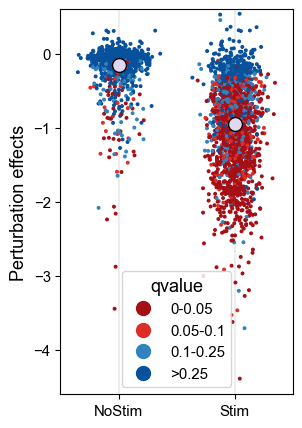

In [53]:
with plt.rc_context({'figure.figsize': (3, 5),'font.sans-serif':['Arial']}):
    fig, ax = plt.subplots(1)
    scprep.plot.jitter(jitterdata['cell_state'], jitterdata['CATE'], c=jitterdata['qvalue_cat'], 
                   cmap=qvalue_cmap,legend=True, plot_means=False, xlabel=False, ylabel='Perturbation effects',fontsize=9,legend_title='qvalue',
                   ax=ax)
    means = jitterdata.groupby('cell_state')['CATE'].mean()
    ax.scatter(means.index, means, color='#e0d8f0', edgecolor='k', s=100)
    ax.set_ylim(-4.6,0.6)
    # plt.savefig(os.path.join(fig_path1,'Tcells_jitter_all.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="22"></a> 
## 4.3 specify subclusters

In [54]:
adata_subset_stim=adata_subset[adata_subset.obs.state=='Stim']

In [55]:
target='LCP2'
factor=6
# basal
basal_subset=basal[basal.obs.condition.isin([target,'control'])]
basal_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
basal_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
basal_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\3906416516.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  basal_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]


In [56]:
basal_subset_stim=basal_subset[basal_subset.obs.state=='Stim']

In [57]:
basal_subset_stim_new = sc.AnnData(X=np.c_[basal_subset_stim.X,basal_subset_stim.obs.te*3],
                        obs=basal_subset_stim.obs)

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\128724183.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  basal_subset_stim_new = sc.AnnData(X=np.c_[basal_subset_stim.X,basal_subset_stim.obs.te*3],


In [58]:
sc.pp.neighbors(basal_subset_stim_new, n_neighbors=10)
sc.tl.umap(basal_subset_stim_new)
sc.tl.leiden(basal_subset_stim_new,resolution=0.23)

In [59]:
adata_subset_stim.obs['leiden']=basal_subset_stim_new.obs['leiden']
basal_subset_stim.obs['leiden']=basal_subset_stim_new.obs['leiden']

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\3723590987.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset_stim.obs['leiden']=basal_subset_stim_new.obs['leiden']
C:\Users\17794\AppData\Local\Temp\ipykernel_21236\3723590987.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  basal_subset_stim.obs['leiden']=basal_subset_stim_new.obs['leiden']


In [60]:
rename_dict={'1':'1','3':'2','2':'4','0':'3'}
adata_subset_stim.obs["leiden"].replace(rename_dict, inplace=True)
basal_subset_stim.obs["leiden"].replace(rename_dict, inplace=True)

In [61]:
adata_subset_stim.uns['leiden_colors']=['#ff7f0e', '#d62728' , '#1f77b4','#2ca02c']

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


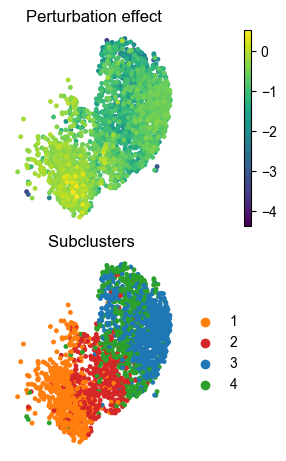

In [62]:
with plt.rc_context({'figure.figsize': (5.5/2, 4.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,constrained_layout=True)
    sc.pl.umap(adata_subset_stim,color='te',title='Perturbation effect',frameon=False,ax=axs[0],show=False)
    sc.pl.umap(adata_subset_stim,color='leiden',title='Subclusters ',frameon=False,ax=axs[1],show=False)
    #plt.savefig(os.path.join(fig_path1,'Tcells_LCP2_subclusters_UMAP_new.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="23"></a> 
## 4.4 Jitter plot of subclusters

In [63]:
jitterdata=pd.DataFrame(np.array([adata_subset_stim.obs.te,
                         adata_subset_stim.obs.qvalue,
                         adata_subset_stim.obs.leiden]).T,columns=['CATE','qvalue','cell_state'],index=adata_subset_stim.obs_names)

In [64]:
jitterdata['cell_type_ID'] = scprep.utils.sort_clusters_by_values(jitterdata['cell_state'], jitterdata['CATE'])
qvalue_cat=[]
for i in range(jitterdata.shape[0]):
    if ((jitterdata['qvalue'][i]>=0)&(jitterdata['qvalue'][i]<=0.05)):
        qvalue_cat.extend(['0-0.05'])
    elif ((jitterdata['qvalue'][i]>0.05)&(jitterdata['qvalue'][i]<=0.1)):
        qvalue_cat.extend(['0.05-0.1'])
    elif ((jitterdata['qvalue'][i]>0.1)&(jitterdata['qvalue'][i]<=0.25)):
        qvalue_cat.extend(['0.1-0.25'])
    else:
        qvalue_cat.extend(['>0.25'])

jitterdata['qvalue_cat']=qvalue_cat
qvalue_cmap = { '0-0.05': '#a50f15',
                '0.05-0.1': '#de2d26',
                 '0.1-0.25': '#3182bd',
                 '>0.25': '#08519c'}

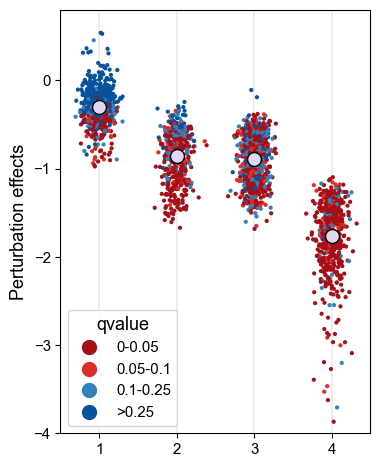

In [65]:
with plt.rc_context({'figure.figsize': (4, 5.5),'font.sans-serif':['Arial']}):
    fig, ax = plt.subplots(1)
    scprep.plot.jitter(jitterdata['cell_state'], jitterdata['CATE'], c=jitterdata['qvalue_cat'], 
                   cmap=qvalue_cmap,legend=True, plot_means=False, xlabel=False, ylabel='Perturbation effects',fontsize=9,legend_title='qvalue',
                   ax=ax)
    means = jitterdata.groupby('cell_state')['CATE'].mean()
    ax.scatter(means.index, means, color='#e0d8f0', edgecolor='k', s=100)
    ax.set_ylim([-4,0.8])
    # Axis tick labels
    #ax.set_xticklabels(jitterdata.set_index('cell_state')['cell_state'].drop_duplicates().sort_index(),fontsize=11)
    #plt.savefig(os.path.join(fig_path1,'Tcells_jitter_subcluster_new.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="24"></a> 
## 4.5 Draw density plots to validate

In [66]:
density_df=adata_subset_stim.obs.loc[:,['factor7','leiden','control']]

In [67]:
sub_density_df=density_df.loc[density_df['leiden']=='0',:]
subsub_density_df_ctrl=sub_density_df.loc[sub_density_df['control']==1,:]
subsub_density_df_pert=sub_density_df.loc[sub_density_df['control']==0,:]

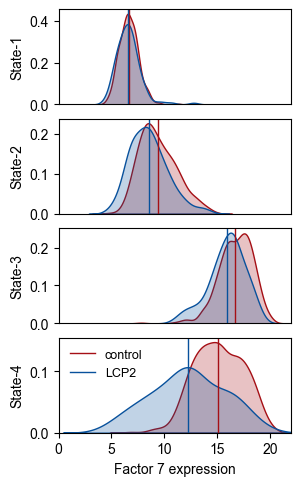

In [68]:
with plt.rc_context({'figure.figsize': (3, 5.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(4,1,gridspec_kw = {'wspace':0, 'hspace':0.15})
    for i in range(4):
        sub_density_df=density_df.loc[density_df['leiden']==str(i+1),:]
        subsub_density_df_ctrl=sub_density_df.loc[sub_density_df['control']==1,:]
        subsub_density_df_pert=sub_density_df.loc[sub_density_df['control']==0,:]
        sns.kdeplot(subsub_density_df_ctrl['factor7'], shade=True, color="#a50f15",ax=axs[i])
        axs[i].set_xlabel(' ')
        axs[i].set_ylabel('State-{}'.format(i+1))
        axs[i].set_xlim([0,22])
        if i!=3:
            axs[i].set_xticks([])
        axs[i].axvline(x=np.mean(subsub_density_df_ctrl['factor7']), color='#a50f15', ls='-', lw=1, label='control')
        sns.kdeplot(subsub_density_df_pert['factor7'], shade=True, color="#08519c",ax=axs[i])
        axs[i].axvline(x=np.mean(subsub_density_df_pert['factor7']), color='#08519c', ls='-', lw=1, label='LCP2')
    
    
    axs[3].set_xlabel('Factor 7 expression')
    plt.legend(fontsize=9, frameon=False)
    #plt.savefig(os.path.join(fig_path1,'Tcells_validation_subcluster.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="25"></a> 
## 4.6 The relationship between CATE and marker gene expression (LCP2→Factor7)

In [69]:
target='LCP2'
factor=6
# draw on orginal transcriptome
adata_subset=adata[adata.obs.condition.isin([target,'control'])]
adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]
adata_subset.obs['qvalue']=tau_q_val_factor_all_dict[target][:,factor]
adata_subset.obs['sig']=[str(i) for i in sig_factor_all_dict[target][:,factor]]

C:\Users\17794\AppData\Local\Temp\ipykernel_21236\1975770146.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['te']=tau_factor_mean_all_dict[target][:,factor]


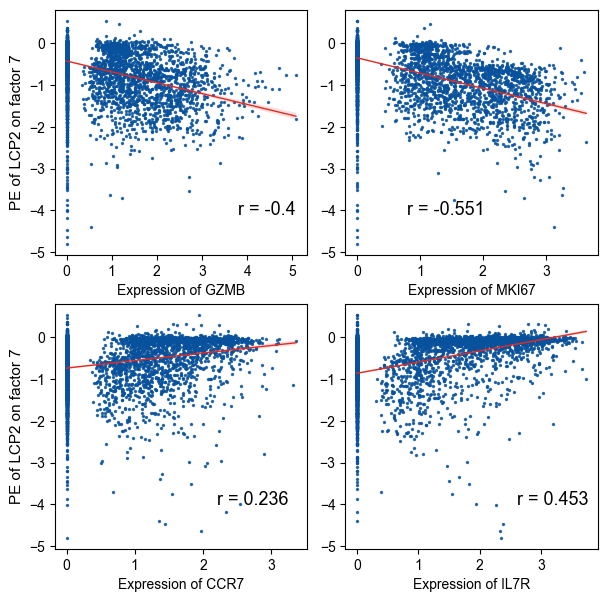

In [70]:
with plt.rc_context({'figure.figsize': (7, 7),'font.sans-serif':['Arial']}):
    
    fig,axs=plt.subplots(2,2,gridspec_kw = {'wspace':0.15, 'hspace':0.2})
    
    sns.regplot(x=adata_subset[:,'GZMB'].X.A[:,0], y=adata_subset.obs['te'],ax=axs[0][0],
                scatter_kws={'s':2,'color':'#08519c'},line_kws={'color':'#de2d26','linewidth':1})
    r=round(np.corrcoef(adata_subset[:,'GZMB'].X.A[:,0],adata_subset.obs['te'])[1,0],3)
    axs[0][0].set_xlabel('Expression of GZMB',fontsize=10)
    axs[0][0].set_ylabel('PE of LCP2 on factor 7',fontsize=11)
    axs[0][0].text(x=3.8,y=-4.1,s='r = {}'.format(r),fontsize=13)
    
    sns.regplot(x=adata_subset[:,'MKI67'].X.A[:,0], y=adata_subset.obs['te'],ax=axs[0][1],
                scatter_kws={'s':2,'color':'#08519c'},line_kws={'color':'#de2d26','linewidth':1})
    r=round(np.corrcoef(adata_subset[:,'MKI67'].X.A[:,0],adata_subset.obs['te'])[1,0],3)
    axs[0][1].set_xlabel('Expression of MKI67',fontsize=10)
    axs[0][1].set_ylabel('')
    axs[0][1].text(x=0.8,y=-4.1,s='r = {}'.format(r),fontsize=13)
    
    
    
    sns.regplot(x=adata_subset[:,'CCR7'].X.A[:,0], y=adata_subset.obs['te'],ax=axs[1][0]
                ,scatter_kws={'s':2,'color':'#08519c'},line_kws={'color':'#de2d26','linewidth':1})
    r=round(np.corrcoef(adata_subset[:,'CCR7'].X.A[:,0],adata_subset.obs['te'])[1,0],3)
    axs[1][0].set_xlabel('Expression of CCR7',fontsize=10)
    axs[1][0].set_ylabel('PE of LCP2 on factor 7',fontsize=11)
    axs[1][0].text(x=2.2,y=-4.0,s='r = {}'.format(r),fontsize=13)

    
    sns.regplot(x=adata_subset[:,'IL7R'].X.A[:,0], y=adata_subset.obs['te'],ax=axs[1][1],
                scatter_kws={'s':2,'color':'#08519c'},line_kws={'color':'#de2d26','linewidth':1})
    r=round(np.corrcoef(adata_subset[:,'IL7R'].X.A[:,0],adata_subset.obs['te'])[1,0],3)
    axs[1][1].set_xlabel('Expression of IL7R',fontsize=10)
    axs[1][1].set_ylabel('')
    axs[1][1].text(x=2.6,y=-4.0,s='r = {}'.format(r),fontsize=13)
    #plt.savefig(os.path.join(fig_path1,'Tcells_CATE_marker_corr.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="26"></a> 
## 4.7 The relationship between CATE and marker gene expression (targets→Factor3)

In [71]:
corrdata=np.zeros([4,len(tau_factor_mean_all_dict.keys())])
markers=['GZMB','MKI67','CCR7','IL7R']
for j in range(len(tau_factor_mean_all_dict.keys())):
    target=list(tau_factor_mean_all_dict.keys())[j]
    adata_subset=adata[adata.obs.condition.isin([target,'control'])]
    y=tau_factor_mean_all_dict[target][:,2]
    for i in range(len(markers)):
        marker=markers[i]
        x=adata_subset[:,marker].X.A[:,0]
        corrdata[i,j]=np.corrcoef(x,y)[0,1]

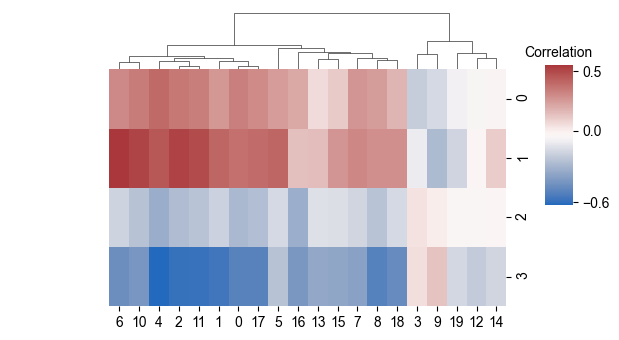

In [72]:
kws = dict(cbar_kws=dict(ticks=[-0.6, 0, 0.5], orientation='vertical'),figsize=(5.5, 3.5))
with plt.rc_context({'figure.figsize': (4, 4),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(corrdata,row_cluster=False,dendrogram_ratio=0.2,cmap="vlag",**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([1, 0.4, 0.05, 0.4])
    g.ax_cbar.set_title('Correlation',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    plt.show()

In [73]:
reorder=np.array([int(i.get_text()) for i in labels])

In [74]:
corrdata_df=pd.DataFrame(corrdata[:,reorder],index=markers,columns=np.array(list(tau_factor_mean_all_dict.keys()))[reorder])

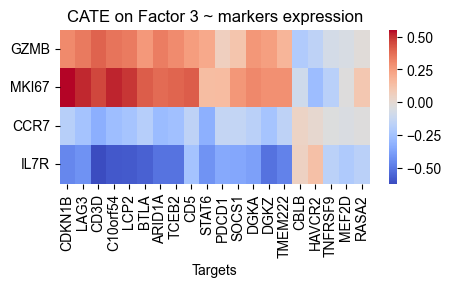

In [75]:
with plt.rc_context({'figure.figsize': (5, 2),'font.sans-serif':['Arial']}):
    sns.heatmap(corrdata_df,cmap=sns.color_palette("coolwarm", as_cmap=True))
    plt.xlabel('Targets')
    plt.title('CATE on Factor 3 ~ markers expression')
    #plt.savefig(os.path.join(fig_path2,'Tcells_CATE_marker_corr_factor3.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="27"></a> 
## 4.8 The relationship between CATE and marker gene expression (targets→Factor7)

In [76]:
corrdata2=np.zeros([4,len(tau_factor_mean_all_dict.keys())])
markers=['GZMB','MKI67','CCR7','IL7R']
for j in range(len(tau_factor_mean_all_dict.keys())):
    target=list(tau_factor_mean_all_dict.keys())[j]
    adata_subset=adata[adata.obs.condition.isin([target,'control'])]
    y=tau_factor_mean_all_dict[target][:,6]
    for i in range(len(markers)):
        marker=markers[i]
        x=adata_subset[:,marker].X.A[:,0]
        corrdata2[i,j]=np.corrcoef(x,y)[0,1]

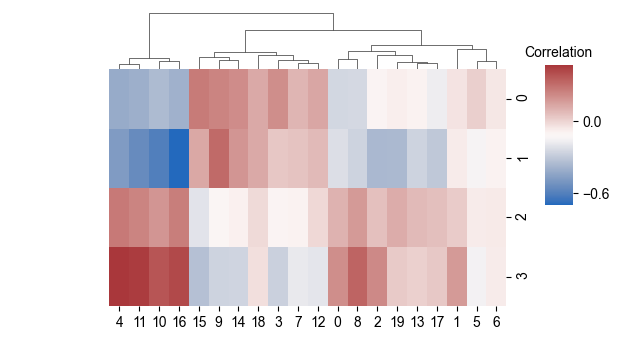

In [77]:
kws = dict(cbar_kws=dict(ticks=[-0.6, 0, 0.5], orientation='vertical'),figsize=(5.5, 3.5))
with plt.rc_context({'figure.figsize': (4, 4),'font.sans-serif':['Arial']}):
    #sns.set(font_scale=0.7,font='Arial')
    g=sns.clustermap(corrdata2,row_cluster=False,dendrogram_ratio=0.2,cmap="vlag",**kws)
    labels=g.ax_heatmap.xaxis.get_majorticklabels()
    #g.ax_col_dendrogram.set_visible(False)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([1, 0.4, 0.05, 0.4])
    g.ax_cbar.set_title('Correlation',fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=3)
    plt.show()

In [78]:
reorder=np.array([int(i.get_text()) for i in labels])
corrdata2_df=pd.DataFrame(corrdata2[:,reorder],index=markers,columns=np.array(list(tau_factor_mean_all_dict.keys()))[reorder])

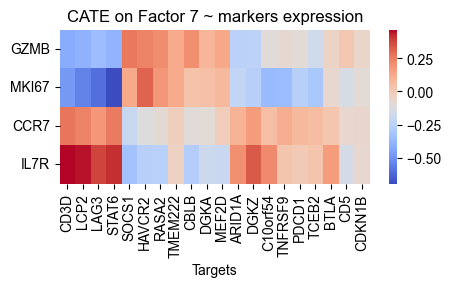

In [79]:
with plt.rc_context({'figure.figsize': (5, 2),'font.sans-serif':['Arial']}):
    sns.heatmap(corrdata2_df,cmap=sns.color_palette("coolwarm", as_cmap=True))
    plt.xlabel('Targets')
    plt.title('CATE on Factor 7 ~ markers expression')
    #plt.savefig(os.path.join(fig_path2,'Tcells_CATE_marker_corr_factor7.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

<a id="28"></a> 
# 5 Factor-level perts distance, and overall perts distance

<a id="29"></a> 
## 5.1 Factor 7 (cell proliferation)  perts distance, aggregating on stim/unstim cells

### Aggregating on Stim cells

In [84]:
distance_df=sccape.cal_factor_level_similarity(adata, tau_factor_mean_all_dict, factor=6, cluster_name='Stim', aggregate_key='state',
                                pert_key='condition')

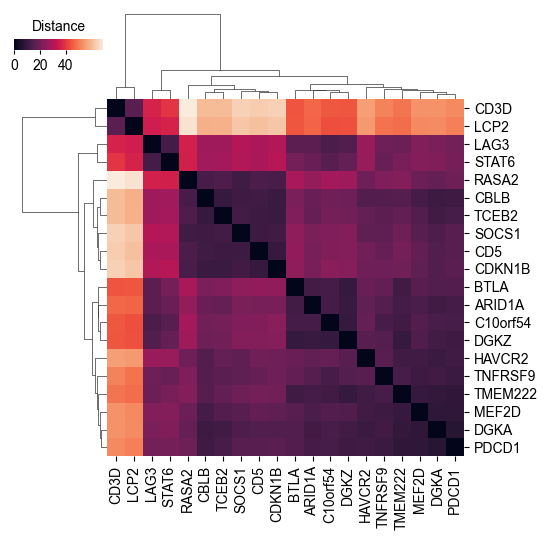

In [85]:
plotting.plot_similarity(distance_df, colorbar_ticks=[0,20,40],figsize=(5.5,5.5),name='factor7_Stim',save_path=fig_path2,save=False)

### Aggregating on Unstim cells

In [86]:
distance_df=sccape.cal_factor_level_similarity(adata, tau_factor_mean_all_dict, factor=6, cluster_name='NoStim', aggregate_key='state',
                                pert_key='condition')

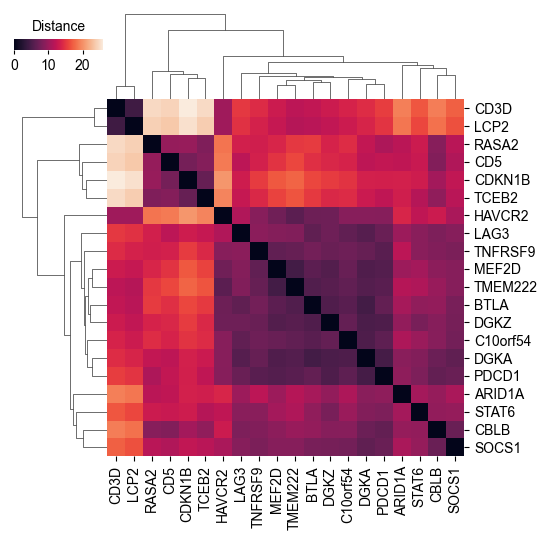

In [87]:
plotting.plot_similarity(distance_df, colorbar_ticks=[0,10,20],figsize=(5.5,5.5),name='factor7_NoStim',save_path=fig_path2,save=False)

<a id="30"></a> 
## 5.2 Overall distance, aggregating on stim/unstim cells

In [88]:
num_genes_go=[len(genes_do_go[key]) for key in genes_do_go.keys()]
factor_weights=np.array(num_genes_go)/sum(num_genes_go)

### Aggregating on Stim cells

In [89]:
distance_df=sccape.cal_overall_similarity(adata, tau_factor_mean_all_dict, factor_weights, cluster_name='Stim', aggregate_key='state',
                           pert_key='condition')

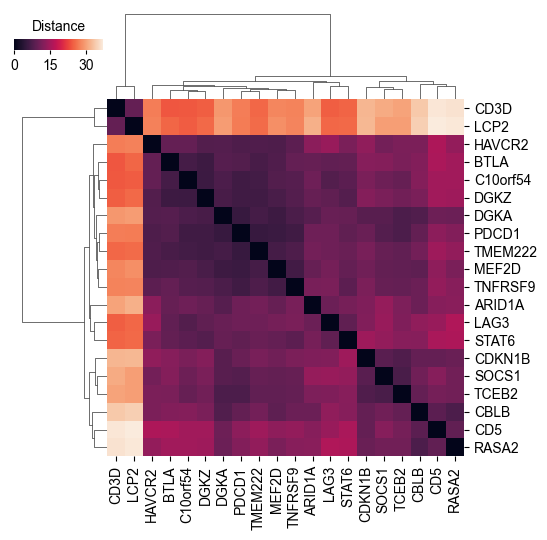

In [90]:
plotting.plot_similarity(distance_df, colorbar_ticks=[0,15,30],name='all_Stim',save_path=fig_path2,save=False)

### Aggregating on Unstim cells

In [91]:
distance_df=sccape.cal_overall_similarity(adata, tau_factor_mean_all_dict, factor_weights, cluster_name='NoStim', aggregate_key='state',
                           pert_key='condition')

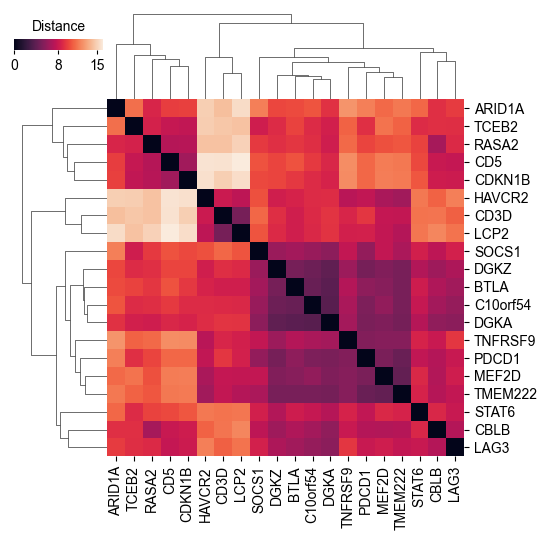

In [92]:
plotting.plot_similarity(distance_df, colorbar_ticks=[0,8,15],name='all_NoStim',save_path=fig_path2,save=False)

<a id="31"></a> 
# 6 Factor-level perts rank, and overall perts rank

<a id="32"></a> 
## 6.1 Factor-level perturbation rank, aggregating on Stim/unstim cells

### Aggregating on Stim cells

In [93]:
pert_factor_rank_dict=sccape.cal_factor_level_rank(clust_mean_df, cluster_name='Stim', absolute_val=True)

In [94]:
pert_factor_rank_dict

{'0': array(['CD3D', 'LCP2', 'RASA2', 'CBLB', 'CD5', 'HAVCR2', 'BTLA',
        'TNFRSF9', 'TMEM222', 'DGKA', 'C10orf54', 'PDCD1', 'ARID1A',
        'SOCS1', 'CDKN1B', 'MEF2D', 'LAG3', 'TCEB2', 'DGKZ', 'STAT6'],
       dtype=object),
 '1': array(['LCP2', 'CD3D', 'BTLA', 'ARID1A', 'CD5', 'CBLB', 'LAG3',
        'C10orf54', 'MEF2D', 'DGKZ', 'TNFRSF9', 'RASA2', 'STAT6', 'DGKA',
        'PDCD1', 'SOCS1', 'TCEB2', 'CDKN1B', 'TMEM222', 'HAVCR2'],
       dtype=object),
 '2': array(['CD3D', 'LCP2', 'CD5', 'RASA2', 'CBLB', 'ARID1A', 'CDKN1B', 'DGKA',
        'LAG3', 'TCEB2', 'HAVCR2', 'BTLA', 'SOCS1', 'TNFRSF9', 'MEF2D',
        'C10orf54', 'DGKZ', 'STAT6', 'PDCD1', 'TMEM222'], dtype=object),
 '3': array(['LCP2', 'CD3D', 'CD5', 'RASA2', 'CDKN1B', 'ARID1A', 'CBLB',
        'SOCS1', 'TCEB2', 'DGKA', 'TMEM222', 'MEF2D', 'BTLA', 'LAG3',
        'TNFRSF9', 'C10orf54', 'STAT6', 'HAVCR2', 'PDCD1', 'DGKZ'],
       dtype=object),
 '4': array(['ARID1A', 'LCP2', 'CBLB', 'RASA2', 'SOCS1', 'CD5', 'STAT6', 'B

### Aggregating on Unstim cells

In [95]:
pert_factor_rank_dict=sccape.cal_factor_level_rank(clust_mean_df, cluster_name='NoStim', absolute_val=True)

In [96]:
pert_factor_rank_dict

{'0': array(['TCEB2', 'CDKN1B', 'BTLA', 'TMEM222', 'C10orf54', 'HAVCR2',
        'TNFRSF9', 'DGKZ', 'ARID1A', 'CD3D', 'SOCS1', 'MEF2D', 'DGKA',
        'RASA2', 'STAT6', 'CBLB', 'LAG3', 'PDCD1', 'CD5', 'LCP2'],
       dtype=object),
 '1': array(['LCP2', 'CD5', 'ARID1A', 'STAT6', 'BTLA', 'TCEB2', 'CDKN1B',
        'CD3D', 'PDCD1', 'SOCS1', 'MEF2D', 'DGKZ', 'LAG3', 'TMEM222',
        'TNFRSF9', 'DGKA', 'RASA2', 'HAVCR2', 'C10orf54', 'CBLB'],
       dtype=object),
 '2': array(['CD5', 'ARID1A', 'CDKN1B', 'RASA2', 'LAG3', 'TCEB2', 'STAT6',
        'DGKA', 'CBLB', 'C10orf54', 'SOCS1', 'BTLA', 'DGKZ', 'TMEM222',
        'PDCD1', 'MEF2D', 'HAVCR2', 'TNFRSF9', 'CD3D', 'LCP2'],
       dtype=object),
 '3': array(['TCEB2', 'CDKN1B', 'RASA2', 'CD5', 'STAT6', 'ARID1A', 'CBLB',
        'SOCS1', 'DGKZ', 'LAG3', 'C10orf54', 'HAVCR2', 'BTLA', 'DGKA',
        'TMEM222', 'LCP2', 'TNFRSF9', 'PDCD1', 'CD3D', 'MEF2D'],
       dtype=object),
 '4': array(['ARID1A', 'RASA2', 'CBLB', 'CDKN1B', 'CD5', 'BTLA', 'CD

<a id="33"></a> 
## 6.2 Overall perturbation rank, aggregating on stim/unstim cells

### Aggregating on Stim cells

In [97]:
sccape.cal_overall_rank(clust_mean_df, cluster_name='Stim', factor_weights=factor_weights, absolute_val=True)

array(['LCP2', 'CD3D', 'CD5', 'RASA2', 'CBLB', 'ARID1A', 'LAG3', 'CDKN1B',
       'SOCS1', 'TCEB2', 'STAT6', 'BTLA', 'DGKA', 'HAVCR2', 'DGKZ',
       'C10orf54', 'TMEM222', 'MEF2D', 'TNFRSF9', 'PDCD1'], dtype=object)

### Aggregating on Unstim cells

In [98]:
sccape.cal_overall_rank(clust_mean_df, cluster_name='NoStim', factor_weights=factor_weights, absolute_val=True)

array(['CDKN1B', 'CD5', 'ARID1A', 'TCEB2', 'RASA2', 'LAG3', 'CBLB',
       'STAT6', 'SOCS1', 'DGKA', 'C10orf54', 'BTLA', 'DGKZ', 'CD3D',
       'HAVCR2', 'PDCD1', 'TMEM222', 'MEF2D', 'LCP2', 'TNFRSF9'],
      dtype=object)

<a id="34"></a> 
# 7 Overall perturbation ranking along the stim trajectory

<a id="35"></a> 
## 7.1 Constructing a trajectory 

In [99]:
adata_ctrl=adata[adata.obs.condition=='control']
sc.tl.pca(adata_ctrl, svd_solver='arpack')
sc.pp.neighbors(adata_ctrl, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata_ctrl)
#sc.pl.draw_graph(adata_ctrl, color='cell_type')

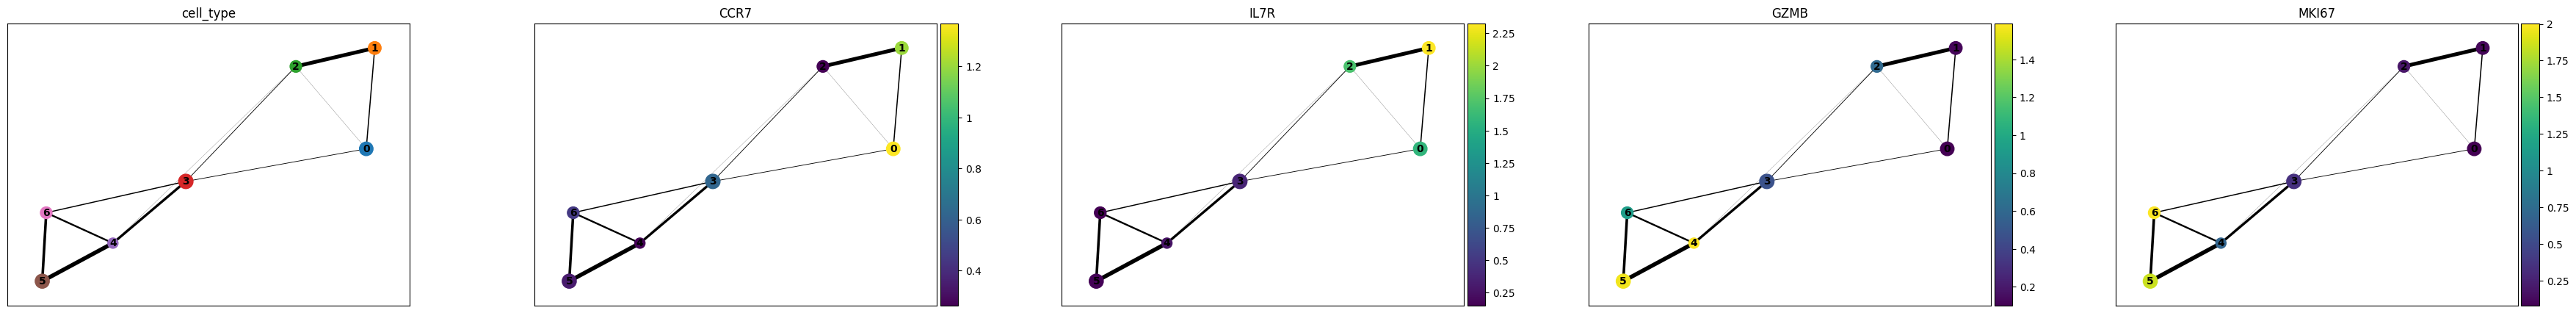

In [100]:
sc.tl.paga(adata_ctrl, groups='cell_type')
sc.pl.paga(adata_ctrl, color=['cell_type', 'CCR7','IL7R','GZMB','MKI67'])

In [101]:
sc.tl.draw_graph(adata_ctrl, init_pos='paga')

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


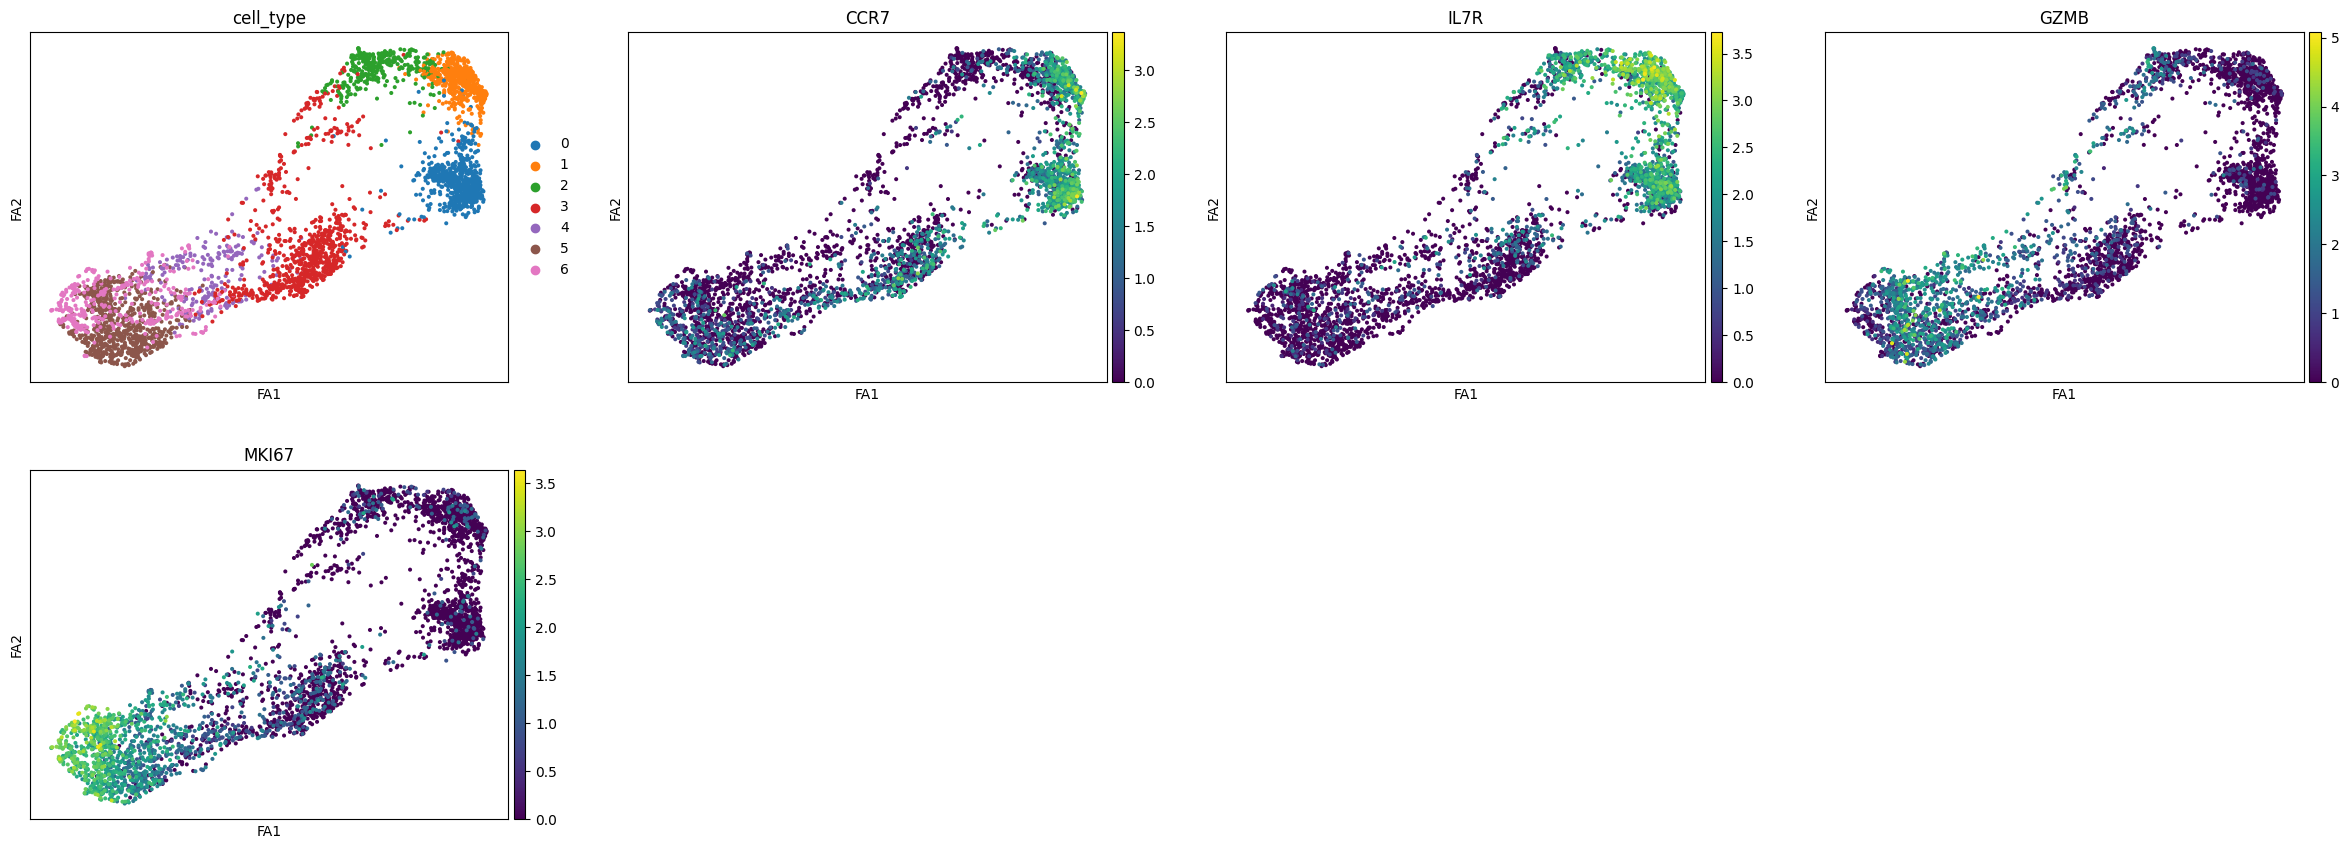

In [102]:
sc.pl.draw_graph(adata_ctrl, color=['cell_type', 'CCR7','IL7R','GZMB','MKI67'])

In [103]:
adata_ctrl.uns['iroot'] = np.flatnonzero(adata_ctrl.obs['cell_type']  == '0')[0]

In [104]:
sc.tl.dpt(adata_ctrl)

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


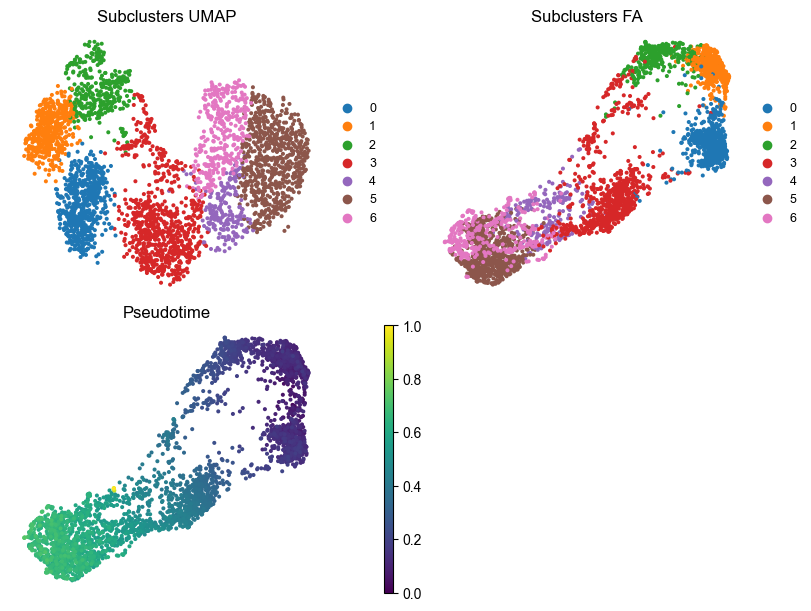

In [105]:
with plt.rc_context({'figure.figsize': (8, 6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,2,constrained_layout=True)
    sc.pl.umap(adata_ctrl,color='cell_type',title='Subclusters UMAP',frameon=False,legend_fontsize=9,ax=axs[0][0],show=False)
    sc.pl.draw_graph(adata_ctrl,color='cell_type',title='Subclusters FA',frameon=False,legend_fontsize=9,ax=axs[0][1],show=False)
    sc.pl.draw_graph(adata_ctrl,color='dpt_pseudotime',title='Pseudotime',frameon=False,ax=axs[1][0],show=False)
    axs[1,1].axis('off')
    #plt.savefig(os.path.join(fig_path2,'Tcells_trajectory1.svg'),bbox_inches='tight',dpi=1000)
    plt.show()

In [106]:
paths =  [0,1,2,3,4,5,6]
gene_names = ['CCR7','IL7R','GZMB','MKI67']

In [107]:
adata_ctrl.obs['subcluster']=adata_ctrl.obs['cell_type']

C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\paga.py:1228: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
C:\ProgramData\anaconda\lib\site-packages\scanpy\plotting\_tools\paga.py:1277: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


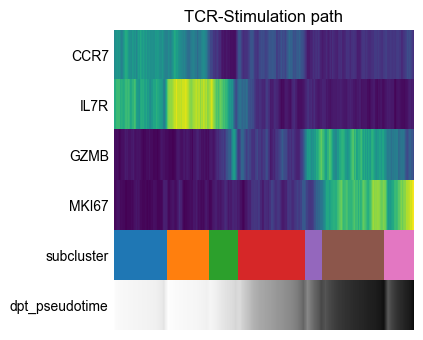

In [108]:
with plt.rc_context({'figure.figsize': (4, 2.6),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(1)
    sc.pl.paga_path(
            adata_ctrl, paths, gene_names,
            show_node_names=False,
            ytick_fontsize=10,
            title_fontsize=12,
            left_margin=0.15,
            n_avg=50,
            show_yticks=True,
            show_colorbar=False,
            color_map='viridis',
            groups_key='subcluster',
            title='{} path'.format('TCR-Stimulation'),ax=axs)
    #fig.savefig(os.path.join(fig_path2,'Tcells_trajectory2.svg'),bbox_inches='tight')
    plt.show()

<a id="36"></a> 
## 7.2 Overall perturbation ranking lists aggregated on these subclusters

In [109]:
num_genes_go=[len(genes_do_go[key]) for key in genes_do_go.keys()]
factor_weights=np.array(num_genes_go)/sum(num_genes_go)

In [110]:
clust_mean_df2, clust_sig_df2=sccape.cal_clust_mean(adata, tau_factor_mean_all_dict, sig_factor_all_dict, 
                                                   aggregate_key='cell_type', pert_key='condition')

In this package, the overall perturbation ranking list is obtained by simply calculating weighted ranking lists of the factors. One can use any rank aggregation method like RankAggreg ...

In [111]:
subcluster_list=list(adata.obs.cell_type.cat.categories)
overall_ranklist=[]
for subcluster in subcluster_list:
    overall_ranklist.append(sccape.cal_overall_rank(clust_mean_df2, cluster_name=subcluster, factor_weights=factor_weights, absolute_val=True))

In [112]:
overall_ranklist

[array(['CD5', 'CDKN1B', 'TCEB2', 'ARID1A', 'RASA2', 'STAT6', 'LAG3',
        'CBLB', 'SOCS1', 'DGKA', 'C10orf54', 'DGKZ', 'BTLA', 'HAVCR2',
        'PDCD1', 'LCP2', 'CD3D', 'TMEM222', 'TNFRSF9', 'MEF2D'],
       dtype=object),
 array(['ARID1A', 'CDKN1B', 'RASA2', 'TCEB2', 'CD5', 'STAT6', 'LAG3',
        'CBLB', 'DGKA', 'BTLA', 'SOCS1', 'C10orf54', 'DGKZ', 'CD3D',
        'TMEM222', 'PDCD1', 'LCP2', 'MEF2D', 'TNFRSF9', 'HAVCR2'],
       dtype=object),
 array(['CDKN1B', 'CD5', 'ARID1A', 'RASA2', 'TCEB2', 'SOCS1', 'LAG3',
        'CBLB', 'DGKA', 'BTLA', 'CD3D', 'C10orf54', 'HAVCR2', 'MEF2D',
        'DGKZ', 'STAT6', 'LCP2', 'TMEM222', 'PDCD1', 'TNFRSF9'],
       dtype=object),
 array(['CD3D', 'CD5', 'LCP2', 'CDKN1B', 'RASA2', 'ARID1A', 'TCEB2',
        'CBLB', 'LAG3', 'SOCS1', 'HAVCR2', 'DGKA', 'STAT6', 'TNFRSF9',
        'BTLA', 'TMEM222', 'PDCD1', 'C10orf54', 'DGKZ', 'MEF2D'],
       dtype=object),
 array(['CD3D', 'LCP2', 'RASA2', 'CD5', 'CBLB', 'CDKN1B', 'SOCS1',
        'ARID1A', 'LA

In [113]:
val_dict={}
for pert in list(adata.obs.condition.cat.categories):
    if pert!='control':
        val_dict[pert]=[]
        for i in range(len(overall_ranklist)):
            val_dict[pert].append(np.where(overall_ranklist[i]==pert)[0][0]+1)

In [114]:
from mplsoccer import Bumpy

In [116]:
cell_state = subcluster_list
highlight_dict=dict(zip(list(adata.obs.condition.cat.categories), list(adata.uns['condition_colors'])))
highlight_dict.pop('control',None)

'#8dd593'

In [117]:
highlight_dict2 = dict(((key, highlight_dict[key]) for key in ['LCP2','CD3D','CBLB','CDKN1B','TCEB2','CD5','ARID1A']) )

In [118]:
bumpy = Bumpy(
    #background_color="#F6F6F6", scatter_color="#808080",
    background_color="white", scatter_color="#808080",
    label_color="#000000", line_color="#C0C0C0",
    rotate_xticks=0,  # rotate x-ticks by 90 degrees
    ticklabel_size=8, label_size=10,  # ticklable and label font-size
    scatter_points='.',   # other markers
    scatter_primary='D',  # marker to be used for teams
    scatter_size=50,   # size of the marker
    show_right=False,  # show position on the rightside
    plot_labels=True,  # plot the labels
    alignment_yvalue=0.5,  # y label alignment
    alignment_xvalue=0.5  # x label alignment
)

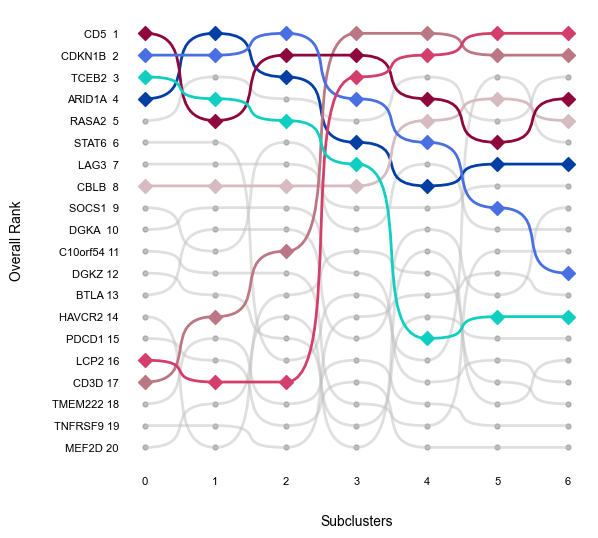

In [119]:
with plt.rc_context({'font.sans-serif':['Arial']}):
    fig, ax = bumpy.plot(
        x_list=cell_state,  # match-day or match-week
        y_list=np.linspace(1, 20, 20).astype(int),  # position value from 1 to 20
        #y_list=list(val_dict.keys()),
        values=val_dict,  # values having positions for each team
        secondary_alpha=0.5,   # alpha value for non-shaded lines/markers
        highlight_dict=highlight_dict2,  # team to be highlighted with their colors
        figsize=(6, 6),  # size of the figure
        x_label='Subclusters', y_label='Overall Rank',  # label name
        ylim=(-0.1, 21.1),  # y-axis limit
        lw=2.,   # linewidth of the connecting lines
        #fontproperties=font_normal.prop,   # fontproperties for ticklables/labels
    )

    yticks_lbl=[]
    for i in range(len(overall_ranklist[0])):
        if i<10:
            yticks_lbl.append(overall_ranklist[0][i]+'  '+str(i+1))
        else:
            yticks_lbl.append(overall_ranklist[0][i]+' '+str(i+1))
    ax.set_yticks(ax.get_yticks(),yticks_lbl[::-1])
    #fig.savefig(os.path.join('all_figs','Similarity_ranking_figs','Tcells_ranklist_trajectory.svg'),bbox_inches='tight')
    plt.show()

In [120]:
psetime_df=adata_ctrl.obs.groupby('cell_type').median(0)

C:\ProgramData\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: Dropping invalid columns in DataFrameGroupBy.median is deprecated. In a future version, a TypeError will be raised. Before calling .median, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [121]:
marker_df=pd.DataFrame(adata_ctrl[:,['CCR7','IL7R','GZMB','MKI67']].X.A,columns=['CCR7','IL7R','GZMB','MKI67'])
marker_df['cell_type']=list(adata_ctrl.obs.cell_type.values)
marker_df=marker_df.groupby('cell_type').mean(0)
marker_df['pseudotime']=psetime_df['dpt_pseudotime'].values

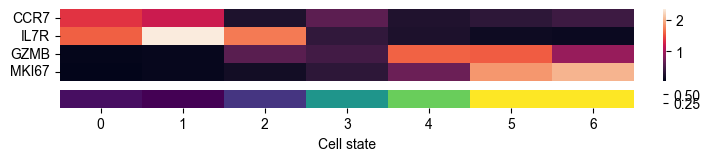

In [122]:
with plt.rc_context({'figure.figsize': (7, 1.5),'font.sans-serif':['Arial']}):
    fig,axs=plt.subplots(2,1,constrained_layout=True,gridspec_kw={'height_ratios': [4, 1]})
    sns.heatmap(marker_df.loc[:,['CCR7','IL7R','GZMB','MKI67']].T,cmap=sns.color_palette("rocket", as_cmap=True),ax=axs[0])
    axs[0].set_xlabel('')
    axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    sns.heatmap(marker_df.loc[:,['pseudotime']].T,cmap=sns.color_palette("viridis", as_cmap=True),ax=axs[1])
    #axs[1].set_yticks([0],'pseudotime',rotation=0)
    axs[1].set_yticks(axs[1].get_yticks(), axs[1].get_yticklabels(), rotation=0, ha='right')
    axs[1].set_xlabel('Cell state')
    #fig.savefig(os.path.join('all_figs','Similarity_ranking_figs','Tcells_trajectory_heatmap.svg'),bbox_inches='tight')
    plt.show()